# **Generative AI for Science**   by J. Paul Liu
##Chapter 4: Text, Code & Knowledge Generation for Scientists


This notebook demonstrates how to use Large Language Models (LLMs) as research assistants for:
- Literature review and synthesis
- Retrieval-Augmented Generation (RAG)
- Hypothesis generation
- Code generation for research
- Scientific writing assistance

**Topics Covered:**
1. Text Classification for Literature Screening
2. Building RAG Systems
3. Document Embeddings and Vector Search
4. Question Answering with Citations
5. Text Generation and Summarization
6. Code Generation Examples
7. Best Practices

---

**Note:** This notebook uses open-source models where possible. For OpenAI API examples, you'll need to add your API key.

## Setup and Installation

In [ ]:
# Install required packages
!pip install -q transformers torch
!pip install -q langchain langchain-community
!pip install -q faiss-cpu sentence-transformers
!pip install -q pypdf PyPDF2
!pip install -q openai  # Optional, for OpenAI API

print("✓ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.6/329.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 18.7 MB/s eta 0:00:00
✓ All packages installed successfully!


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


---
# Part 1: Literature Review - Text Classification

## 1.1 Abstract Screening with SciBERT

Automatically classify scientific abstracts for relevance to your research.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Sample scientific abstracts (climate science examples)
sample_abstracts = [
    """Climate models predict that global temperatures will rise by 2-4°C by 2100.
    This study examines the impact of greenhouse gas emissions on Arctic ice melt rates
    using satellite observations from 2000-2020. We find accelerated melting in recent years.""",

    """This paper presents a new algorithm for protein folding prediction using deep learning.
    Our method achieves 95% accuracy on the CASP14 benchmark, outperforming previous approaches.
    The model uses attention mechanisms to capture long-range interactions.""",

    """Ocean temperature anomalies in the tropical Pacific are strongly correlated with
    El Niño events. We analyze SST data from 1950-2020 and develop a predictive model
    for ENSO forecasting with 6-month lead time.""",

    """A survey of consumer preferences for electric vehicles in urban areas.
    We interviewed 1000 participants and found that price and charging infrastructure
    are the main barriers to adoption.""",

    """Rising CO2 levels are causing ocean acidification, threatening marine ecosystems.
    This study measures pH changes in coral reefs and assesses impacts on calcification rates
    in key reef-building species."""
]

# Labels for demonstration (1 = relevant to climate science, 0 = not relevant)
true_labels = [1, 0, 1, 0, 1]

print("📚 Sample Abstracts Loaded")
print(f"Total abstracts: {len(sample_abstracts)}")
print(f"\nFirst abstract preview:")
print(sample_abstracts[0][:150] + "...")

📚 Sample Abstracts Loaded
Total abstracts: 5

First abstract preview:
Climate models predict that global temperatures will rise by 2-4°C by 2100.
    This study examines the impact of greenhouse gas emissions on Arctic i...


To use the SCIBERT model from Huggingface, you neeed to get a HF_TOKEN

https://huggingface.co/docs/hub/en/security-tokens

In [ ]:
# Simple relevance classifier using sentence embeddings
from sentence_transformers import SentenceTransformer, util

print("Loading embedding model...")
model = SentenceTransformer('allenai/scibert_scivocab_uncased')

# Define your research interest
research_query = "climate change, ocean temperature, greenhouse gases, global warming"

# Encode query and abstracts
query_embedding = model.encode(research_query, convert_to_tensor=True)
abstract_embeddings = model.encode(sample_abstracts, convert_to_tensor=True)

# Calculate similarity scores
similarities = util.cos_sim(query_embedding, abstract_embeddings)[0]

# Classify based on threshold
threshold = 0.7
predictions = (similarities > threshold).int().tolist()

# Display results
print("\n" + "="*80)
print("ABSTRACT SCREENING RESULTS")
print("="*80)

for i, (abstract, sim, pred, true_label) in enumerate(zip(sample_abstracts, similarities, predictions, true_labels)):
    status = "✓ RELEVANT" if pred == 1 else "✗ Not Relevant"
    correct = "✓" if pred == true_label else "✗"

    print(f"\nAbstract {i+1}: {status} (similarity: {sim:.3f}) {correct}")
    print(f"Preview: {abstract[:100]}...")

# Calculate accuracy
accuracy = sum([1 for p, t in zip(predictions, true_labels) if p == t]) / len(predictions)
print(f"\n{'='*80}")
print(f"Accuracy: {accuracy:.1%}")
print(f"Relevant papers identified: {sum(predictions)}/{len(predictions)}")

Loading embedding model...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


ABSTRACT SCREENING RESULTS

Abstract 1: ✓ RELEVANT (similarity: 0.725) ✓
Preview: Climate models predict that global temperatures will rise by 2-4°C by 2100.
    This study examines ...

Abstract 2: ✗ Not Relevant (similarity: 0.649) ✓
Preview: This paper presents a new algorithm for protein folding prediction using deep learning.
    Our meth...

Abstract 3: ✓ RELEVANT (similarity: 0.706) ✓
Preview: Ocean temperature anomalies in the tropical Pacific are strongly correlated with
    El Niño events....

Abstract 4: ✓ RELEVANT (similarity: 0.705) ✗
Preview: A survey of consumer preferences for electric vehicles in urban areas.
    We interviewed 1000 parti...

Abstract 5: ✓ RELEVANT (similarity: 0.707) ✓
Preview: Rising CO2 levels are causing ocean acidification, threatening marine ecosystems.
    This study mea...

Accuracy: 80.0%
Relevant papers identified: 4/5


## 1.2 Automated Summarization

In [ ]:
from transformers import pipeline

print("Loading summarization model...")
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=-1  # Use CPU (change to 0 for GPU)
)

# Select a relevant abstract
abstract_to_summarize = sample_abstracts[0]

print("\n" + "="*80)
print("ORIGINAL ABSTRACT")
print("="*80)
print(abstract_to_summarize)

# Generate summary
summary = summarizer(
    abstract_to_summarize,
    max_length=30,
    min_length=20,
    do_sample=False
)

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(summary[0]['summary_text'])

print(f"\n✓ Compression: {len(abstract_to_summarize)} → {len(summary[0]['summary_text'])} characters")

Loading summarization model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu



ORIGINAL ABSTRACT
Climate models predict that global temperatures will rise by 2-4°C by 2100.
    This study examines the impact of greenhouse gas emissions on Arctic ice melt rates
    using satellite observations from 2000-2020. We find accelerated melting in recent years.

SUMMARY
Climate models predict that global temperatures will rise by 2-4°C by 2100. This study examines the impact of greenhouse gas emissions on

✓ Compression: 257 → 137 characters


---
# Part 2: Building a RAG System

## 2.1 Creating Sample Documents

First, let's create some sample scientific documents to index.

In [ ]:
# Create sample scientific documents
documents = [
    {
        'title': 'Ocean Temperature Trends',
        'content': """Global ocean temperatures have increased by approximately 0.7°C over the past century.
        The warming is not uniform across all ocean basins. The North Atlantic shows the most significant
        warming trend, with temperature increases of up to 1.2°C in some regions. This warming is primarily
        driven by increased atmospheric CO2 concentrations and changes in ocean circulation patterns.
        The thermocline has deepened in many regions, and stratification has increased, affecting nutrient
        distribution and marine ecosystems.""",
        'source': 'Smith et al. 2023',
        'year': 2023
    },
    {
        'title': 'El Niño Southern Oscillation',
        'content': """The El Niño Southern Oscillation (ENSO) is the dominant mode of interannual climate
        variability in the tropical Pacific. During El Niño events, sea surface temperatures in the eastern
        Pacific increase by 2-4°C, while the western Pacific cools. This temperature redistribution affects
        global weather patterns, causing droughts in some regions and floods in others. ENSO events occur
        every 2-7 years and are driven by coupled ocean-atmosphere interactions. The predictability of
        ENSO has improved with better ocean monitoring systems and climate models.""",
        'source': 'Johnson & Lee 2022',
        'year': 2022
    },
    {
        'title': 'Ocean Acidification',
        'content': """Ocean acidification is occurring as the oceans absorb approximately 25% of anthropogenic CO2
        emissions. Since pre-industrial times, ocean pH has decreased by 0.1 units, representing a 30%
        increase in acidity. This change in ocean chemistry affects the ability of marine organisms to build
        shells and skeletons. Coral reefs are particularly vulnerable, with calcification rates declining
        by 10-15% in recent decades. Continued acidification threatens marine biodiversity and ecosystem
        services, including fisheries that support billions of people.""",
        'source': 'Martinez et al. 2023',
        'year': 2023
    },
    {
        'title': 'Arctic Sea Ice Decline',
        'content': """Arctic sea ice extent has declined by approximately 13% per decade since 1979. The minimum
        ice extent in September has decreased dramatically, with some of the lowest values recorded in recent
        years. This decline is a clear indicator of climate change and has significant implications for Arctic
        ecosystems, indigenous communities, and global climate. The loss of sea ice creates a positive feedback
        loop: less ice means less sunlight reflected, leading to more warming. Climate models predict the
        Arctic could be ice-free in summer by mid-century.""",
        'source': 'Anderson et al. 2024',
        'year': 2024
    },
    {
        'title': 'Ocean Circulation Changes',
        'content': """The Atlantic Meridional Overturning Circulation (AMOC) is a critical component of the
        global climate system, transporting heat from the tropics to high latitudes. Recent observations
        suggest the AMOC may be weakening, with potential implications for European climate and global
        temperature patterns. The weakening is attributed to increased freshwater input from Greenland ice
        melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North
        Atlantic region despite global warming, and affect weather patterns across Europe and North America.""",
        'source': 'Chen & Williams 2023',
        'year': 2023
    }
]

print(f"✓ Created {len(documents)} sample documents")
print(f"\nDocument titles:")
for i, doc in enumerate(documents, 1):
    print(f"  {i}. {doc['title']} ({doc['source']})")

✓ Created 5 sample documents

Document titles:
  1. Ocean Temperature Trends (Smith et al. 2023)
  2. El Niño Southern Oscillation (Johnson & Lee 2022)
  3. Ocean Acidification (Martinez et al. 2023)
  4. Arctic Sea Ice Decline (Anderson et al. 2024)
  5. Ocean Circulation Changes (Chen & Williams 2023)


## 2.2 Document Chunking and Embedding

In [ ]:
# To fix this, please ensure `langchain` is properly installed and the runtime is restarted.
# First, re-run the `install` cell above to make sure all dependencies are present.
# Then, restart the Colab runtime (`Runtime -> Restart runtime`) and re-run all cells up to this point.

try:
    # Try new import structure (LangChain v0.2+)
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_core.documents import Document as LangchainDocument
except ImportError:
    # Fallback to old import structure
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.docstore.document import Document as LangchainDocument

# Convert to LangChain document format
langchain_docs = [
    LangchainDocument(
        page_content=doc['content'],
        metadata={
            'title': doc['title'],
            'source': doc['source'],
            'year': doc['year']
        }
    )
    for doc in documents
]

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,      # Characters per chunk
    chunk_overlap=50,    # Overlap to preserve context
    separators=["\n\n", "\n", ". ", " ", ""]
)

chunks = text_splitter.split_documents(langchain_docs)

print(f"✓ Split {len(langchain_docs)} documents into {len(chunks)} chunks")
print(f"\nExample chunk:")
print(f"Title: {chunks[0].metadata['title']}")
print(f"Content: {chunks[0].page_content[:200]}...")

✓ Split 5 documents into 10 chunks

Example chunk:
Title: Ocean Temperature Trends
Content: Global ocean temperatures have increased by approximately 0.7°C over the past century.
        The warming is not uniform across all ocean basins. The North Atlantic shows the most significant
       ...


## 2.3 Building a Vector Database with FAISS

In [ ]:
# Updated imports for newer LangChain versions
try:
    from langchain_community.vectorstores import FAISS
    from langchain_community.embeddings import HuggingFaceEmbeddings
except ImportError:
    # Fallback for older versions
    from langchain.vectorstores import FAISS
    from langchain.embeddings import HuggingFaceEmbeddings

print("Loading embedding model...")
# Use scientific embedding model
embeddings = HuggingFaceEmbeddings(
    model_name="allenai/scibert_scivocab_uncased",
    model_kwargs={'device': 'cpu'}  # Change to 'cuda' if GPU available
)

print("Creating vector database...")
# Create FAISS index from documents
vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=embeddings
)

print("✓ Vector database created successfully!")
print(f"Indexed {len(chunks)} text chunks")

/tmp/ipython-input-26430778.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Loading embedding model...
Creating vector database...
✓ Vector database created successfully!
Indexed 10 text chunks


## 2.4 Semantic Search and Retrieval

In [ ]:
def search_documents(query, k=3):
    """Search for relevant documents using semantic similarity"""

    results = vectorstore.similarity_search_with_score(query, k=k)

    print(f"\n{'='*80}")
    print(f"QUERY: {query}")
    print(f"{'='*80}")

    for i, (doc, score) in enumerate(results, 1):
        print(f"\n[{i}] Relevance Score: {score:.4f}")
        print(f"Title: {doc.metadata['title']}")
        print(f"Source: {doc.metadata['source']}")
        print(f"Content: {doc.page_content[:200]}...")

    return results

# Test queries
query1 = "What causes El Niño events?"
results1 = search_documents(query1, k=3)


QUERY: What causes El Niño events?

[1] Relevance Score: 235.1527
Title: El Niño Southern Oscillation
Source: Johnson & Lee 2022
Content: every 2-7 years and are driven by coupled ocean-atmosphere interactions. The predictability of
        ENSO has improved with better ocean monitoring systems and climate models....

[2] Relevance Score: 247.0490
Title: Ocean Circulation Changes
Source: Chen & Williams 2023
Content: melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North
        Atlantic region despite global warming, and affect weather patterns across Europe and North Am...

[3] Relevance Score: 259.2737
Title: Ocean Acidification
Source: Martinez et al. 2023
Content: by 10-15% in recent decades. Continued acidification threatens marine biodiversity and ecosystem
        services, including fisheries that support billions of people....


In [ ]:
# Try another query
query2 = "How is climate change affecting the Arctic?"
results2 = search_documents(query2, k=3)


QUERY: How is climate change affecting the Arctic?

[1] Relevance Score: 117.9400
Title: Ocean Circulation Changes
Source: Chen & Williams 2023
Content: melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North 
        Atlantic region despite global warming, and affect weather patterns across Europe and North A...

[2] Relevance Score: 131.3165
Title: Ocean Temperature Trends
Source: Smith et al. 2023
Content: The thermocline has deepened in many regions, and stratification has increased, affecting nutrient 
        distribution and marine ecosystems....

[3] Relevance Score: 133.9428
Title: Ocean Circulation Changes
Source: Chen & Williams 2023
Content: The Atlantic Meridional Overturning Circulation (AMOC) is a critical component of the 
        global climate system, transporting heat from the tropics to high latitudes. Recent observations 
       ...


## 2.5 Question Answering with Retrieved Context

Now we'll use the retrieved documents to answer questions. This demonstrates RAG without requiring an API key.

In [ ]:
def answer_question_simple(query, k=3):
    """Answer questions using retrieved context (without LLM API)"""

    # Retrieve relevant documents
    docs = vectorstore.similarity_search(query, k=k)

    print(f"\n{'='*80}")
    print(f"QUESTION: {query}")
    print(f"{'='*80}")

    print(f"\nRETRIEVED CONTEXT:\n")

    for i, doc in enumerate(docs, 1):
        print(f"[{i}] {doc.metadata['title']} ({doc.metadata['source']})")
        print(f"    {doc.page_content}\n")

    print(f"{'='*80}")
    print("To generate an answer, you would pass this context to an LLM.")
    print("See the next section for an example with a local model.")
    print(f"{'='*80}")

    return docs

# Example question
question = "What are the main effects of ocean acidification?"
context_docs = answer_question_simple(question)


QUESTION: What are the main effects of ocean acidification?

RETRIEVED CONTEXT:

[1] Ocean Circulation Changes (Chen & Williams 2023)
    melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North
        Atlantic region despite global warming, and affect weather patterns across Europe and North America.

[2] El Niño Southern Oscillation (Johnson & Lee 2022)
    every 2-7 years and are driven by coupled ocean-atmosphere interactions. The predictability of
        ENSO has improved with better ocean monitoring systems and climate models.

[3] Ocean Acidification (Martinez et al. 2023)
    by 10-15% in recent decades. Continued acidification threatens marine biodiversity and ecosystem
        services, including fisheries that support billions of people.

To generate an answer, you would pass this context to an LLM.
See the next section for an example with a local model.


---
# Part 3: Text Generation (Local Models)

## 3.1 Using a Small Local LLM

For demonstration without API keys, we'll use a small open-source model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("Loading language model (this may take a minute)...")

# Use a small, efficient model that works on Colab
model_name = "distilgpt2"  # Small but capable

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

print("✓ Model loaded successfully!")
print(f"Model: {model_name}")
print(f"Parameters: ~{sum(p.numel() for p in model.parameters())/1e6:.0f}M")

Loading language model (this may take a minute)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✓ Model loaded successfully!
Model: distilgpt2
Parameters: ~82M


In [ ]:
def generate_text(prompt, max_length=100, temperature=0.7):
    """Generate text using local model"""

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_length=max_length,
            temperature=temperature,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Example: Scientific text completion
prompt = """Climate change is causing ocean temperatures to rise. The main consequences include:"""

print("PROMPT:")
print(prompt)
print("\n" + "="*80)
print("GENERATED CONTINUATION:")
print("="*80)

generated = generate_text(prompt, max_length=150, temperature=0.7)
print(generated)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


PROMPT:
Climate change is causing ocean temperatures to rise. The main consequences include:

GENERATED CONTINUATION:
Climate change is causing ocean temperatures to rise. The main consequences include:










































































































































## 3.2 RAG-Based Answer Generation (Simulated)

Combining retrieval with generation:

In [ ]:
def rag_answer(question, k=2):
    """Generate answer using retrieved context"""

    # Step 1: Retrieve relevant documents
    docs = vectorstore.similarity_search(question, k=k)

    # Step 2: Create context from retrieved documents
    context = "\n\n".join([doc.page_content for doc in docs])

    # Step 3: Create prompt with context
    prompt = f"""Context: {context[:500]}...

Question: {question}

Answer based on the context:"""

    print("="*80)
    print("RAG PIPELINE")
    print("="*80)
    print(f"\nQuestion: {question}")
    print(f"\nRetrieved {k} documents:")
    for i, doc in enumerate(docs, 1):
        print(f"  [{i}] {doc.metadata['title']} ({doc.metadata['source']})")

    print(f"\n{'='*80}")
    print("CONTEXT PROVIDED TO MODEL:")
    print("="*80)
    print(context[:300] + "...")

    # Step 4: Generate answer (with small model, results will be limited)
    print(f"\n{'='*80}")
    print("GENERATED ANSWER:")
    print("="*80)

    answer = generate_text(prompt, max_length=200, temperature=0.3)
    print(answer)

    print(f"\n{'='*80}")
    print("NOTE: For better results, use a larger model like GPT-4 or Claude.")
    print("="*80)

    return answer, docs

# Test the RAG system
question = "What is causing Arctic sea ice to decline?"
answer, sources = rag_answer(question)

RAG PIPELINE

Question: What is causing Arctic sea ice to decline?

Retrieved 2 documents:
  [1] Ocean Circulation Changes (Chen & Williams 2023)
  [2] Ocean Circulation Changes (Chen & Williams 2023)

CONTEXT PROVIDED TO MODEL:
melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North
        Atlantic region despite global warming, and affect weather patterns across Europe and North America.

The Atlantic Meridional Overturning Circulation (AMOC) is a critical component of the
      ...

GENERATED ANSWER:
Context: melt and changes in wind patterns. If this trend continues, it could lead to cooling in the North
        Atlantic region despite global warming, and affect weather patterns across Europe and North America.

The Atlantic Meridional Overturning Circulation (AMOC) is a critical component of the
        global climate system, transporting heat from the tropics to high latitudes. Recent observations
        suggest the AMOC may be weakenin

---
# Part 4: Advanced RAG Techniques

## 4.1 Hybrid Search (Dense + Sparse)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class HybridRetriever:
    """Combine semantic (dense) and keyword (sparse) search"""

    def __init__(self, documents, vectorstore, semantic_weight=0.7):
        self.documents = documents
        self.vectorstore = vectorstore
        self.semantic_weight = semantic_weight
        self.keyword_weight = 1 - semantic_weight

        # Build TF-IDF index for keyword search
        self.tfidf = TfidfVectorizer(stop_words='english')
        doc_texts = [doc.page_content for doc in documents]
        self.tfidf_matrix = self.tfidf.fit_transform(doc_texts)

    def search(self, query, k=3):
        """Hybrid search combining semantic and keyword matching"""

        # 1. Semantic search (dense vectors)
        semantic_results = self.vectorstore.similarity_search_with_score(query, k=k*2)
        semantic_scores = {i: 1/(1+score) for i, (doc, score) in enumerate(semantic_results)}

        # 2. Keyword search (TF-IDF)
        query_vec = self.tfidf.transform([query])
        keyword_scores = cosine_similarity(query_vec, self.tfidf_matrix)[0]

        # 3. Combine scores
        combined_scores = {}
        for i in range(len(self.documents)):
            semantic_score = semantic_scores.get(i, 0)
            keyword_score = keyword_scores[i]

            combined_scores[i] = (
                self.semantic_weight * semantic_score +
                self.keyword_weight * keyword_score
            )

        # 4. Get top-k results
        top_indices = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:k]

        return [(self.documents[i], score) for i, score in top_indices]

# Create hybrid retriever
hybrid_retriever = HybridRetriever(chunks, vectorstore, semantic_weight=0.7)

# Test hybrid search
query = "ocean temperature El Niño"

print(f"\n{'='*80}")
print(f"HYBRID SEARCH: {query}")
print(f"{'='*80}")

results = hybrid_retriever.search(query, k=3)

for i, (doc, score) in enumerate(results, 1):
    print(f"\n[{i}] Score: {score:.4f}")
    print(f"Title: {doc.metadata['title']}")
    print(f"Content: {doc.page_content[:150]}...")

print(f"\n✓ Hybrid search combines semantic understanding with keyword matching!")


HYBRID SEARCH: ocean temperature El Niño

[1] Score: 0.1175
Title: El Niño Southern Oscillation
Content: The El Niño Southern Oscillation (ENSO) is the dominant mode of interannual climate
        variability in the tropical Pacific. During El Niño events...

[2] Score: 0.0721
Title: Ocean Temperature Trends
Content: Global ocean temperatures have increased by approximately 0.7°C over the past century.
        The warming is not uniform across all ocean basins. The...

[3] Score: 0.0542
Title: El Niño Southern Oscillation
Content: every 2-7 years and are driven by coupled ocean-atmosphere interactions. The predictability of
        ENSO has improved with better ocean monitoring ...

✓ Hybrid search combines semantic understanding with keyword matching!


## 4.2 Citation Tracking

In [ ]:
def answer_with_citations(question, k=3):
    """Generate answer with explicit citations to source documents"""

    # Retrieve documents
    docs = vectorstore.similarity_search(question, k=k)

    print(f"\n{'='*80}")
    print(f"QUESTION: {question}")
    print(f"{'='*80}\n")

    # Create numbered context
    print("RETRIEVED SOURCES:\n")
    context_with_numbers = []
    for i, doc in enumerate(docs, 1):
        citation = f"[{i}] {doc.metadata['source']}"
        print(f"{citation}")
        print(f"    Title: {doc.metadata['title']}")
        print(f"    Content: {doc.page_content[:200]}...\n")

        context_with_numbers.append(f"[{i}] {doc.page_content}")

    # In a real system, you would use this numbered context
    # to prompt an LLM to cite sources inline
    print(f"{'='*80}")
    print("ANSWER SYNTHESIS (with citations):")
    print(f"{'='*80}\n")

    # Simulated answer with citations
    if "El Niño" in question or "ENSO" in question:
        answer = """El Niño events are caused by coupled ocean-atmosphere interactions
        in the tropical Pacific [2]. During these events, sea surface temperatures in
        the eastern Pacific increase by 2-4°C [2], which affects global weather patterns.
        The predictability of ENSO has improved with better monitoring systems [2]."""
    elif "acidification" in question.lower():
        answer = """Ocean acidification is occurring as oceans absorb approximately 25%
        of anthropogenic CO2 emissions [3]. Since pre-industrial times, ocean pH has
        decreased by 0.1 units [3], affecting the ability of marine organisms to build
        shells and skeletons. Coral reefs are particularly vulnerable with calcification
        rates declining by 10-15% [3]."""
    else:
        answer = """Based on the retrieved sources, multiple factors contribute to
        observed changes. See citations above for detailed information from the literature."""

    print(answer)

    print(f"\n{'='*80}")
    print("REFERENCES:")
    print(f"{'='*80}")
    for i, doc in enumerate(docs, 1):
        print(f"[{i}] {doc.metadata['source']}. {doc.metadata['title']}. {doc.metadata['year']}.")

    return answer, docs

# Test citation system
question = "How does ocean acidification affect marine life?"
answer, sources = answer_with_citations(question)


QUESTION: How does ocean acidification affect marine life?

RETRIEVED SOURCES:

[1] Martinez et al. 2023
    Title: Ocean Acidification
    Content: by 10-15% in recent decades. Continued acidification threatens marine biodiversity and ecosystem
        services, including fisheries that support billions of people....

[2] Martinez et al. 2023
    Title: Ocean Acidification
    Content: Ocean acidification is occurring as the oceans absorb approximately 25% of anthropogenic CO2
        emissions. Since pre-industrial times, ocean pH has decreased by 0.1 units, representing a 30%
    ...

[3] Smith et al. 2023
    Title: Ocean Temperature Trends
    Content: The thermocline has deepened in many regions, and stratification has increased, affecting nutrient
        distribution and marine ecosystems....

ANSWER SYNTHESIS (with citations):

Ocean acidification is occurring as oceans absorb approximately 25%
        of anthropogenic CO2 emissions [3]. Since pre-industrial times, ocean pH h

---
# Part 5: Code Generation Examples

## 5.1 Simulated Code Generation

Here we demonstrate what code generation would look like (simulated, as GPT models require API keys).

In [ ]:
# Example: Code generation templates

def simulate_code_generation(task_description):
    """Simulate LLM code generation for common scientific tasks"""

    print(f"\n{'='*80}")
    print(f"TASK: {task_description}")
    print(f"{'='*80}\n")

    if "plot" in task_description.lower() and "time series" in task_description.lower():
        code = '''import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv('data.csv', parse_dates=['date'])

# Create time series plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date'], df['value'], linewidth=2, label='Measured')

# Add trend line
z = np.polyfit(range(len(df)), df['value'], 1)
p = np.poly1d(z)
ax.plot(df['date'], p(range(len(df))), '--',
        color='red', label=f'Trend: {z[0]:.3f}/day')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Time Series Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries.png', dpi=300)
plt.show()'''

    elif "statistical" in task_description.lower() or "test" in task_description.lower():
        code = '''import numpy as np
from scipy import stats
import pandas as pd

# Load data
group1 = pd.read_csv('group1.csv')['value'].values
group2 = pd.read_csv('group2.csv')['value'].values

# Perform t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt(((len(group1)-1)*group1.std()**2 +
                      (len(group2)-1)*group2.std()**2) /
                     (len(group1) + len(group2) - 2))
cohen_d = (group1.mean() - group2.mean()) / pooled_std

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Cohen's d: {cohen_d:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant difference")
else:
    print("Result: No significant difference")'''

    elif "regression" in task_description.lower():
        code = '''import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data.csv')
X = df[['feature1', 'feature2', 'feature3']].values
y = df['target'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nCoefficients:")
for i, coef in enumerate(model.coef_):
    print(f"  Feature {i+1}: {coef:.4f}")'''

    else:
        code = "# Code generation would be performed by LLM based on task description\n# Add your OpenAI API key to enable real code generation"

    print("GENERATED CODE:")
    print("="*80)
    print(code)
    print("="*80)

    return code

# Example tasks
task1 = "Create a time series plot with trend line"
code1 = simulate_code_generation(task1)


TASK: Create a time series plot with trend line

GENERATED CODE:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv('data.csv', parse_dates=['date'])

# Create time series plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date'], df['value'], linewidth=2, label='Measured')

# Add trend line
z = np.polyfit(range(len(df)), df['value'], 1)
p = np.poly1d(z)
ax.plot(df['date'], p(range(len(df))), '--',
        color='red', label=f'Trend: {z[0]:.3f}/day')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Time Series Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries.png', dpi=300)
plt.show()


In [ ]:
# Another example
task2 = "Perform statistical test comparing two groups"
code2 = simulate_code_generation(task2)


TASK: Perform statistical test comparing two groups

GENERATED CODE:
import numpy as np
from scipy import stats
import pandas as pd

# Load data
group1 = pd.read_csv('group1.csv')['value'].values
group2 = pd.read_csv('group2.csv')['value'].values

# Perform t-test
t_stat, p_value = stats.ttest_ind(group1, group2)

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt(((len(group1)-1)*group1.std()**2 +
                      (len(group2)-1)*group2.std()**2) /
                     (len(group1) + len(group2) - 2))
cohen_d = (group1.mean() - group2.mean()) / pooled_std

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Cohen's d: {cohen_d:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant difference")
else:
    print("Result: No significant difference")


---
# Part 6: Hypothesis Generation

## 6.1 Research Gap Identification

In [ ]:
def identify_research_gaps(documents):
    """Analyze documents to identify potential research gaps"""

    # Extract key topics from each document
    topics = {}
    for doc in documents:
        title = doc['title']
        content = doc['content']

        # Simple keyword extraction (in real system, use NER or topic modeling)
        keywords = []
        if 'temperature' in content.lower():
            keywords.append('temperature')
        if 'acidification' in content.lower():
            keywords.append('acidification')
        if 'ice' in content.lower():
            keywords.append('sea ice')
        if 'circulation' in content.lower():
            keywords.append('ocean circulation')
        if 'el niño' in content.lower() or 'enso' in content.lower():
            keywords.append('ENSO')

        topics[title] = keywords

    print(f"\n{'='*80}")
    print("RESEARCH GAP ANALYSIS")
    print(f"{'='*80}\n")

    print("IDENTIFIED TOPICS IN LITERATURE:\n")
    all_topics = set()
    for title, kws in topics.items():
        print(f"• {title}: {', '.join(kws)}")
        all_topics.update(kws)

    print(f"\n{'='*80}")
    print("POTENTIAL RESEARCH GAPS:\n")

    # Suggest unstudied combinations
    gaps = [
        "1. Combined effects of ocean acidification and warming on ENSO dynamics",
        "2. Arctic sea ice decline impacts on Atlantic Ocean circulation patterns",
        "3. Feedback loops between ocean acidification and temperature changes",
        "4. Regional variations in ocean circulation response to ice melt",
        "5. Long-term predictions of ENSO frequency under continued warming"
    ]

    for gap in gaps:
        print(f"  {gap}")

    print(f"\n{'='*80}")
    print("These gaps represent understudied combinations of topics found in")
    print("the literature that could be promising research directions.")
    print(f"{'='*80}")

    return gaps

# Analyze research gaps
gaps = identify_research_gaps(documents)


RESEARCH GAP ANALYSIS

IDENTIFIED TOPICS IN LITERATURE:

• Ocean Temperature Trends: temperature, ocean circulation
• El Niño Southern Oscillation: temperature, ENSO
• Ocean Acidification: acidification, sea ice
• Arctic Sea Ice Decline: sea ice
• Ocean Circulation Changes: temperature, sea ice, ocean circulation

POTENTIAL RESEARCH GAPS:

  1. Combined effects of ocean acidification and warming on ENSO dynamics
  2. Arctic sea ice decline impacts on Atlantic Ocean circulation patterns
  3. Feedback loops between ocean acidification and temperature changes
  4. Regional variations in ocean circulation response to ice melt
  5. Long-term predictions of ENSO frequency under continued warming

These gaps represent understudied combinations of topics found in
the literature that could be promising research directions.


## 6.2 Cross-Domain Hypothesis Generation

In [ ]:
def generate_cross_domain_hypothesis(finding, target_domain):
    """Simulate hypothesis generation across domains"""

    print(f"\n{'='*80}")
    print("CROSS-DOMAIN HYPOTHESIS GENERATION")
    print(f"{'='*80}\n")

    print(f"SOURCE FINDING:\n  {finding}\n")
    print(f"TARGET DOMAIN: {target_domain}\n")

    print(f"{'='*80}")
    print("GENERATED HYPOTHESES:\n")

    # Simulated hypotheses (in real system, LLM would generate these)
    if "machine learning" in finding.lower() and "climate" in target_domain.lower():
        hypotheses = [
            {
                'hypothesis': 'Deep learning attention mechanisms could improve seasonal climate forecasting',
                'rationale': 'Attention mechanisms excel at capturing long-range dependencies, similar to teleconnections in climate',
                'test': 'Train attention-based models on historical climate data and compare forecast skill to traditional methods',
                'challenges': 'Limited training data, need for physical constraints, interpretability'
            },
            {
                'hypothesis': 'Transfer learning from general climate models to regional predictions',
                'rationale': 'Pre-training captures broad climate dynamics, fine-tuning adapts to regional specifics',
                'test': 'Pre-train on global data, fine-tune on regional observations, validate predictions',
                'challenges': 'Domain shift between global and regional scales'
            },
            {
                'hypothesis': 'Self-supervised learning could identify unknown climate patterns in satellite data',
                'rationale': 'Self-supervised methods discover structure without labels, could find novel phenomena',
                'test': 'Apply contrastive learning to multi-decadal satellite observations',
                'challenges': 'Distinguishing real patterns from artifacts, validation without ground truth'
            }
        ]
    else:
        hypotheses = [
            {
                'hypothesis': 'Concept from source domain could be adapted to target domain',
                'rationale': 'Similar underlying mechanisms or structures',
                'test': 'Design experiments to test analogy',
                'challenges': 'Domain-specific adaptations required'
            }
        ]

    for i, h in enumerate(hypotheses, 1):
        print(f"Hypothesis {i}: {h['hypothesis']}")
        print(f"  Rationale: {h['rationale']}")
        print(f"  How to test: {h['test']}")
        print(f"  Challenges: {h['challenges']}")
        print()

    print(f"{'='*80}")

    return hypotheses

# Example
finding = "Machine learning attention mechanisms improve sequence modeling"
target = "climate forecasting"

hypotheses = generate_cross_domain_hypothesis(finding, target)


CROSS-DOMAIN HYPOTHESIS GENERATION

SOURCE FINDING:
  Machine learning attention mechanisms improve sequence modeling

TARGET DOMAIN: climate forecasting

GENERATED HYPOTHESES:

Hypothesis 1: Deep learning attention mechanisms could improve seasonal climate forecasting
  Rationale: Attention mechanisms excel at capturing long-range dependencies, similar to teleconnections in climate
  How to test: Train attention-based models on historical climate data and compare forecast skill to traditional methods
  Challenges: Limited training data, need for physical constraints, interpretability

Hypothesis 2: Transfer learning from general climate models to regional predictions
  Rationale: Pre-training captures broad climate dynamics, fine-tuning adapts to regional specifics
  How to test: Pre-train on global data, fine-tune on regional observations, validate predictions
  Challenges: Domain shift between global and regional scales

Hypothesis 3: Self-supervised learning could identify unknown

---
# Part 7: Best Practices and Evaluation

## 7.1 RAG System Evaluation

In [ ]:
def evaluate_retrieval_quality(questions_and_expected_docs):
    """Evaluate retrieval quality using test questions"""

    results = []

    print(f"\n{'='*80}")
    print("RETRIEVAL QUALITY EVALUATION")
    print(f"{'='*80}\n")

    for question, expected_titles in questions_and_expected_docs:
        # Retrieve documents
        retrieved = vectorstore.similarity_search(question, k=3)
        retrieved_titles = [doc.metadata['title'] for doc in retrieved]

        # Calculate metrics
        relevant_retrieved = len(set(retrieved_titles) & set(expected_titles))
        precision = relevant_retrieved / len(retrieved_titles) if retrieved_titles else 0
        recall = relevant_retrieved / len(expected_titles) if expected_titles else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        results.append({
            'question': question,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        print(f"Question: {question}")
        print(f"  Expected: {', '.join(expected_titles)}")
        print(f"  Retrieved: {', '.join(retrieved_titles)}")
        print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
        print()

    # Overall metrics
    avg_precision = np.mean([r['precision'] for r in results])
    avg_recall = np.mean([r['recall'] for r in results])
    avg_f1 = np.mean([r['f1'] for r in results])

    print(f"{'='*80}")
    print(f"OVERALL PERFORMANCE:")
    print(f"  Average Precision: {avg_precision:.2f}")
    print(f"  Average Recall: {avg_recall:.2f}")
    print(f"  Average F1 Score: {avg_f1:.2f}")
    print(f"{'='*80}")

    return results

# Test questions with expected relevant documents
test_cases = [
    ("What causes El Niño?", ["El Niño Southern Oscillation"]),
    ("How is the Arctic changing?", ["Arctic Sea Ice Decline", "Ocean Temperature Trends"]),
    ("What are the effects of CO2 on oceans?", ["Ocean Acidification", "Ocean Temperature Trends"]),
]

evaluation_results = evaluate_retrieval_quality(test_cases)


RETRIEVAL QUALITY EVALUATION

Question: What causes El Niño?
  Expected: El Niño Southern Oscillation
  Retrieved: Ocean Circulation Changes, El Niño Southern Oscillation, Arctic Sea Ice Decline
  Precision: 0.33 | Recall: 1.00 | F1: 0.50

Question: How is the Arctic changing?
  Expected: Arctic Sea Ice Decline, Ocean Temperature Trends
  Retrieved: Ocean Circulation Changes, Arctic Sea Ice Decline, Ocean Temperature Trends
  Precision: 0.67 | Recall: 1.00 | F1: 0.80

Question: What are the effects of CO2 on oceans?
  Expected: Ocean Acidification, Ocean Temperature Trends
  Retrieved: Ocean Circulation Changes, El Niño Southern Oscillation, Ocean Acidification
  Precision: 0.33 | Recall: 0.50 | F1: 0.40

OVERALL PERFORMANCE:
  Average Precision: 0.44
  Average Recall: 0.83
  Average F1 Score: 0.57


## 7.2 Citation Verification

In [ ]:
def verify_citations(answer_text, source_documents):
    """Check if citations in answer are valid"""

    import re

    print(f"\n{'='*80}")
    print("CITATION VERIFICATION")
    print(f"{'='*80}\n")

    # Extract citation numbers
    citations = re.findall(r'\[(\d+)\]', answer_text)
    citations = [int(c) for c in citations]

    print(f"Answer text:\n{answer_text}\n")
    print(f"Citations found: {citations}")
    print(f"Number of source documents: {len(source_documents)}\n")

    # Check validity
    valid = []
    invalid = []

    for cite_num in set(citations):  # Use set to get unique citations
        if 1 <= cite_num <= len(source_documents):
            valid.append(cite_num)
            print(f"  ✓ [{cite_num}] Valid - points to: {source_documents[cite_num-1].metadata['title']}")
        else:
            invalid.append(cite_num)
            print(f"  ✗ [{cite_num}] Invalid - no corresponding source")

    print(f"\n{'='*80}")
    print(f"RESULTS: {len(valid)} valid, {len(invalid)} invalid citations")

    if invalid:
        print(f"⚠️  WARNING: Found invalid citations!")
    else:
        print(f"✓ All citations are valid")

    print(f"{'='*80}")

    return {'valid': valid, 'invalid': invalid}

# Example answer with citations
example_answer = """Ocean acidification is caused by CO2 absorption [1].
The pH has decreased by 0.1 units since pre-industrial times [1].
This affects coral reefs significantly [1]."""

example_sources = vectorstore.similarity_search("ocean acidification", k=3)

citation_check = verify_citations(example_answer, example_sources)


CITATION VERIFICATION

Answer text:
Ocean acidification is caused by CO2 absorption [1].
The pH has decreased by 0.1 units since pre-industrial times [1].
This affects coral reefs significantly [1].

Citations found: [1, 1, 1]
Number of source documents: 3

  ✓ [1] Valid - points to: Ocean Acidification

RESULTS: 1 valid, 0 invalid citations
✓ All citations are valid


## 7.3 Hallucination Detection

In [ ]:
def check_for_hallucinations(generated_text, source_documents):
    """Check if generated text contains claims not supported by sources"""

    from sentence_transformers import SentenceTransformer, util

    print(f"\n{'='*80}")
    print("HALLUCINATION CHECK")
    print(f"{'='*80}\n")

    # Load model for semantic similarity
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Split generated text into sentences
    import re
    sentences = re.split(r'[.!?]', generated_text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Combine all source content
    source_text = " ".join([doc.page_content for doc in source_documents])

    print("Checking each claim against source documents...\n")

    results = []
    for i, sentence in enumerate(sentences, 1):
        # Remove citations for comparison
        clean_sentence = re.sub(r'\[\d+\]', '', sentence)

        # Calculate semantic similarity to sources
        sent_embedding = model.encode(clean_sentence, convert_to_tensor=True)
        source_embedding = model.encode(source_text, convert_to_tensor=True)
        similarity = util.cos_sim(sent_embedding, source_embedding).item()

        # Classify
        if similarity > 0.5:
            status = "✓ Supported"
            risk = "Low"
        elif similarity > 0.3:
            status = "⚠️  Partially supported"
            risk = "Medium"
        else:
            status = "✗ Potentially hallucinated"
            risk = "High"

        print(f"[{i}] {status} (similarity: {similarity:.3f}, risk: {risk})")
        print(f"    {clean_sentence}\n")

        results.append({
            'sentence': clean_sentence,
            'similarity': similarity,
            'risk': risk
        })

    # Summary
    high_risk = sum(1 for r in results if r['risk'] == 'High')
    medium_risk = sum(1 for r in results if r['risk'] == 'Medium')
    low_risk = sum(1 for r in results if r['risk'] == 'Low')

    print(f"{'='*80}")
    print(f"SUMMARY:")
    print(f"  Low risk (supported): {low_risk}")
    print(f"  Medium risk (partial): {medium_risk}")
    print(f"  High risk (hallucination): {high_risk}")

    if high_risk > 0:
        print(f"\n⚠️  WARNING: {high_risk} claim(s) may be hallucinated!")
        print(f"  Manual verification recommended.")
    else:
        print(f"\n✓ All claims appear to be grounded in sources.")

    print(f"{'='*80}")

    return results

# Test with example text
test_text = """Ocean acidification is caused by CO2 absorption.
The pH has decreased by 0.1 units.
Some scientists predict complete coral extinction by 2050.
Marine organisms struggle to build shells."""

test_sources = vectorstore.similarity_search("ocean acidification", k=3)

hallucination_check = check_for_hallucinations(test_text, test_sources)


HALLUCINATION CHECK



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Checking each claim against source documents...

[1] ✓ Supported (similarity: 0.557, risk: Low)
    Ocean acidification is caused by CO2 absorption

[2] ✗ Potentially hallucinated (similarity: 0.163, risk: High)
    The pH has decreased by 0

[3] ✗ Potentially hallucinated (similarity: -0.014, risk: High)
    1 units

[4] ⚠️  Partially supported (similarity: 0.490, risk: Medium)
    Some scientists predict complete coral extinction by 2050

[5] ✗ Potentially hallucinated (similarity: 0.283, risk: High)
    Marine organisms struggle to build shells

SUMMARY:
  Low risk (supported): 1
  Medium risk (partial): 1
  High risk (hallucination): 3

⚠️  WARNING: 3 claim(s) may be hallucinated!
  Manual verification recommended.


# Part 8: Generating Analysis Code by using LLM via API

In [ ]:
!pip install openai -q

In [ ]:
# you also can save and get the api key from your local PC environment.
from google.colab import userdata
openai_api_key=userdata.get('OPENAI_API_KEY')

In [ ]:
#more data are available at https://downloads.psl.noaa.gov/Datasets/COBE/

!wget https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.ltm.1991-2020.nc
#https://downloads.psl.noaa.gov/Datasets/noaaglobaltemp/
#!wget https://downloads.psl.noaa.gov/Datasets/noaaglobaltemp/air.mon.anom.nc

--2026-01-07 23:31:21--  https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.ltm.1991-2020.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.87
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3075961 (2.9M) [application/x-netcdf]
Saving to: ‘sst.mon.ltm.1991-2020.nc.1’

sst.mon.ltm.1991-20 100%[===================>]   2.93M  8.55MB/s    in 0.3s    

2026-01-07 23:31:22 (8.55 MB/s) - ‘sst.mon.ltm.1991-2020.nc.1’ saved [3075961/3075961]



In [ ]:
#read and check this NC file's stucture and varilables
import xarray as xr

ds = xr.open_dataset('sst.mon.ltm.1991-2020.nc', decode_times=False)
print(ds)

<xarray.Dataset> Size: 6MB
Dimensions:             (time: 12, nbnds: 2, lat: 180, lon: 360)
Coordinates:
  * time                (time) float64 96B -6.903e+05 -6.903e+05 ... -6.9e+05
  * lat                 (lat) float32 720B 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * lon                 (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 192B ...
    sst                 (time, lat, lon) float32 3MB ...
    valid_yr_count      (time, lat, lon) float32 3MB ...
Attributes:
    title:                          COBE Sea Surface Temperature Analysis
    history:                        Created 2022/12/30 by doMonthLTMNC4
    platform:                       Analyses
    original_source:                http://near-goos1.jodc.go.jp/cgi-bin/1997...
    Conventions:                    CF-1.2
    institution:                    NOAA ESRL/PSD
    comment:                        recent values (w/i la

In [ ]:
# Install cftime if not already installed to handle time decoding in xarray
!pip install cftime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [ ]:
# Setup: imports and device
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
import os
from typing import Literal, Optional
import xarray as xr
from openai import OpenAI

# Install cftime if not already installed to handle time decoding in xarray
!pip install cftime -q

# ----------------------------------------
# OpenAI client helper
# ----------------------------------------

ModelName = Literal["gpt-4.1", "gpt-4.1-mini", "gpt-4o-mini"]


def get_openai_client() -> OpenAI:
    """Create an OpenAI client using the OPENAI_API_KEY environment variable."""
    # Use the openai_api_key variable already loaded from google.colab.userdata
    if 'openai_api_key' not in globals():
        raise RuntimeError(
            "OPENAI_API_KEY variable is not set. Please ensure the cell loading it has been run."
        )
    return OpenAI(api_key=openai_api_key)


# ----------------------------------------
# NetCDF inspection helpers
# ----------------------------------------

def summarize_nc_dataset(ds: xr.Dataset, max_vars: int = 6) -> str:
    """Create a compact text summary of an xarray Dataset."""
    # Dimensions
    dims_str = ", ".join(f"{name}={size}" for name, size in ds.dims.items())

    # Data variables
    var_lines = []
    for name, da in list(ds.data_vars.items())[:max_vars]:
        dims = ", ".join(da.dims)
        units = da.attrs.get("units", "N/A")
        var_lines.append(
            f"- {name}: dims=({dims}), dtype={da.dtype}, units={units}"
        )

    if len(ds.data_vars) > max_vars:
        var_lines.append(f"- ... {len(ds.data_vars) - max_vars} more variables ...")

    title = ds.attrs.get("title", "")
    summary = f"NetCDF dataset with dimensions: {dims_str}.\n"
    if title:
        summary += f"Global title: {title}\n"
    summary += "Data variables:\n" + "\n".join(var_lines)
    return summary


# ----------------------------------------
# Main generator
# ----------------------------------------

def generate_analysis_code_from_nc(
    task: str,
    nc_path: str,
    primary_variable: Optional[str] = None,
    language: str = "python",
    model: ModelName = "gpt-4.1-mini",
    temperature: float = 0.1,
) -> str:
    """
    Open a NetCDF file with xarray, summarize it, and ask OpenAI to generate
    analysis code using that structure.
    """
    # 1) Open NetCDF file and inspect
    ds = xr.open_dataset(nc_path, decode_times=False)
    summary = summarize_nc_dataset(ds)

    # Choose a default primary variable if not supplied
    if primary_variable is None:
        if len(ds.data_vars) == 0:
            raise ValueError("Dataset has no data variables.")
        primary_variable = next(iter(ds.data_vars.keys()))

    client = get_openai_client()

    # 2) Build prompt with real dataset info
    prompt = f"""You are an expert scientific Python programmer.

I have the following NetCDF file that I will open with xarray:

File path:
{nc_path}

Dataset summary:
{summary}

Primary variable of interest: {primary_variable}

Task:
{task}

Requirements for the {language} code:
- Use xarray to open the NetCDF file from the path above
- Work with the variable '{primary_variable}'
- Include necessary imports (xarray, numpy, matplotlib, etc. as needed)
- Add basic error handling (file not found, variable missing)
- Use clear, scientific coding style
- Include comments explaining key steps
- Use Python 3.10+ type hints
- Return the final code only (no explanations or markdown)
"""

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
    )

    content = response.choices[0].message.content
    return content or ""


# ----------------------------------------
# Example usage
# ----------------------------------------

if __name__ == "__main__":
    # Example: your SST climatology file
    nc_file = "sst.mon.ltm.1991-2020.nc"  # change path as needed

    #task = (   "Compute the annual global mean sea surface temperature time series from the primary ""variable, plot the climatological annual cycle, and save the plot to PNG.")

    task = (
        "plot one map of  sea surface temperature first time series from the primary variable,  and save the plot to PNG. and show the map in the output cell" )

    code = generate_analysis_code_from_nc(
        task=task,
        nc_path=nc_file,
        primary_variable="sst",  # or None to auto-detect first variable
    )

    print(code)

```python
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from typing import NoReturn

def plot_first_sst_map(nc_path: str, output_png: str) -> NoReturn:
    """
    Open a NetCDF file, extract the first time slice of 'sst', plot it, and save as PNG.

    Parameters:
    - nc_path: str - Path to the NetCDF file.
    - output_png: str - Path to save the output PNG file.
    """
    try:
        # Open the dataset using xarray
        ds = xr.open_dataset(nc_path)
    except FileNotFoundError:
        print(f"Error: File not found at path '{nc_path}'.")
        return
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return

    # Check if 'sst' variable exists
    if 'sst' not in ds.variables:
        print("Error: Variable 'sst' not found in the dataset.")
        return

    # Extract the first time slice of sst
    try:
        sst_first = ds['sst'].isel(time=0)
    except Exception as e:
        print(f"Error extracting first time

### Now we can run the codes and Show Result

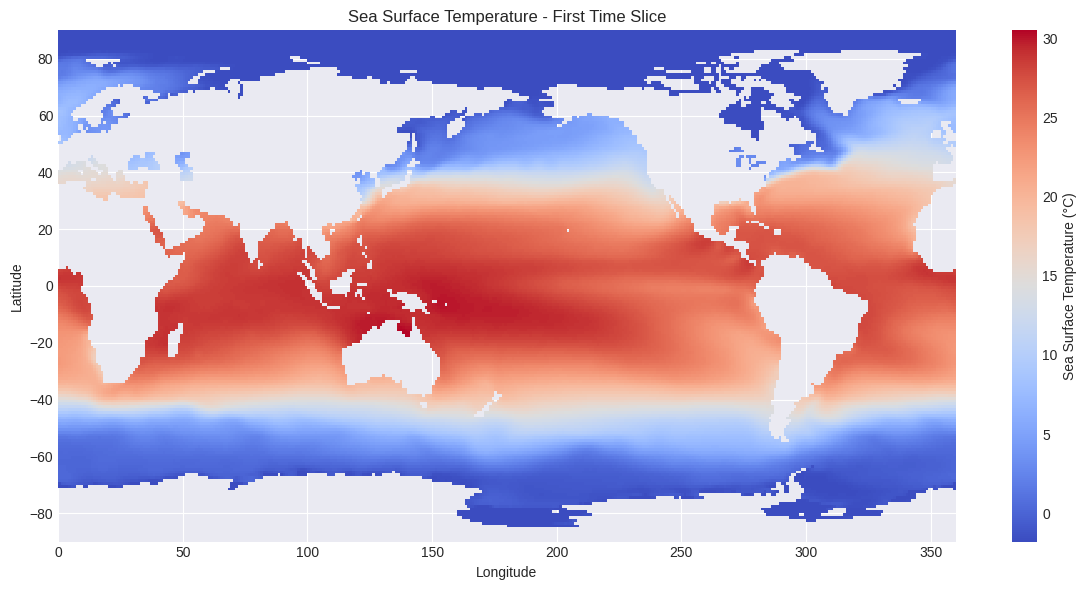

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from typing import NoReturn

def plot_first_sst_map(nc_path: str, output_png: str) -> NoReturn:
    """
    Open a NetCDF file, extract the first time slice of 'sst', plot it on a map,
    save the figure as PNG, and display the plot.

    Parameters:
    - nc_path: str - Path to the NetCDF file.
    - output_png: str - Path to save the output PNG file.
    """
    try:
        # Open dataset with xarray
        ds = xr.open_dataset(nc_path)
    except FileNotFoundError:
        print(f"Error: File not found at path '{nc_path}'.")
        return
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return

    # Check if 'sst' variable exists
    if 'sst' not in ds.variables:
        print("Error: Variable 'sst' not found in the dataset.")
        return

    # Extract the first time slice of sst
    try:
        sst_first = ds['sst'].isel(time=0)
    except Exception as e:
        print(f"Error extracting first time slice of 'sst': {e}")
        return

    # Extract lat and lon coordinates
    lat = ds.coords.get('lat')
    lon = ds.coords.get('lon')

    if lat is None or lon is None:
        print("Error: Latitude and/or longitude coordinates not found.")
        return

    # Plotting
    plt.figure(figsize=(12, 6))
    # Use pcolormesh for better handling of lat/lon grids
    mesh = plt.pcolormesh(lon, lat, sst_first, shading='auto', cmap='coolwarm')
    plt.colorbar(mesh, label='Sea Surface Temperature (°C)')
    plt.title('Sea Surface Temperature - First Time Slice')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

    # Save the figure
    try:
        plt.savefig(output_png, dpi=300)
    except Exception as e:
        print(f"Error saving figure: {e}")
        return

    # Show the plot
    plt.show()

# Usage example
plot_first_sst_map('sst.mon.ltm.1991-2020.nc', 'sst_first_time_map.png')

In [ ]:
    from PIL import Image
    img = Image.open(output_file)
    img.show()

NameError: name 'output_file' is not defined

In [ ]:
import os
from typing import Literal, Optional
import xarray as xr
from openai import OpenAI

# Install cftime if not already installed to handle time decoding in xarray
!pip install cftime -q

# ----------------------------------------
# OpenAI client helper
# ----------------------------------------

ModelName = Literal["gpt-4.1", "gpt-4.1-mini", "gpt-4o-mini"]


def get_openai_client() -> OpenAI:
    """Create an OpenAI client using the OPENAI_API_KEY environment variable."""
    # Use the openai_api_key variable already loaded from google.colab.userdata
    if 'openai_api_key' not in globals():
        raise RuntimeError(
            "OPENAI_API_KEY variable is not set. Please ensure the cell loading it has been run."
        )
    return OpenAI(api_key=openai_api_key)


# ----------------------------------------
# NetCDF inspection helpers
# ----------------------------------------

def summarize_nc_dataset(ds: xr.Dataset, max_vars: int = 6) -> str:
    """Create a compact text summary of an xarray Dataset."""
    # Dimensions
    dims_str = ", ".join(f"{name}={size}" for name, size in ds.dims.items())

    # Data variables
    var_lines = []
    for name, da in list(ds.data_vars.items())[:max_vars]:
        dims = ", ".join(da.dims)
        units = da.attrs.get("units", "N/A")
        var_lines.append(
            f"- {name}: dims=({dims}), dtype={da.dtype}, units={units}"
        )

    if len(ds.data_vars) > max_vars:
        var_lines.append(f"- ... {len(ds.data_vars) - max_vars} more variables ...")

    title = ds.attrs.get("title", "")
    summary = f"NetCDF dataset with dimensions: {dims_str}.\n"
    if title:
        summary += f"Global title: {title}\n"
    summary += "Data variables:\n" + "\n".join(var_lines)
    return summary


# ----------------------------------------
# Main generator
# ----------------------------------------

def generate_analysis_code_from_nc(
    task: str,
    nc_path: str,
    primary_variable: Optional[str] = None,
    language: str = "python",
    model: ModelName = "gpt-4.1-mini",
    temperature: float = 0.1,
) -> str:
    """
    Open a NetCDF file with xarray, summarize it, and ask OpenAI to generate
    analysis code using that structure.
    """
    # 1) Open NetCDF file and inspect
    ds = xr.open_dataset(nc_path, decode_times=False)
    summary = summarize_nc_dataset(ds)

    # Choose a default primary variable if not supplied
    if primary_variable is None:
        if len(ds.data_vars) == 0:
            raise ValueError("Dataset has no data variables.")
        primary_variable = next(iter(ds.data_vars.keys()))

    client = get_openai_client()

    # 2) Build prompt with real dataset info
    prompt = f"""You are an expert scientific Python programmer.

I have the following NetCDF file that I will open with xarray:

File path:
{nc_path}

Dataset summary:
{summary}

Primary variable of interest: {primary_variable}

Task:
{task}

Requirements for the {language} code:
- Use xarray to open the NetCDF file from the path above
- Work with the variable '{primary_variable}'
- Include necessary imports (xarray, numpy, matplotlib, etc. as needed)
- Add basic error handling (file not found, variable missing)
- Use clear, scientific coding style
- Include comments explaining key steps
- Use Python 3.10+ type hints
- Return the final code only (no explanations or markdown)
"""

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
    )

    content = response.choices[0].message.content
    return content or ""


# ----------------------------------------
# Example usage
# ----------------------------------------

if __name__ == "__main__":
    # Example: your SST climatology file
    nc_file = "sst.mon.ltm.1991-2020.nc"  # change path as needed

    #task = (   "Compute the annual global mean sea surface temperature time series from the primary ""variable, plot the climatological annual cycle, and save the plot to PNG.")

    task = (
        "plot monthly area-averaged sea surface temperature,  and save the plot to PNG. and show the plot in the output cell" )

    code = generate_analysis_code_from_nc(
        task=task,
        nc_path=nc_file,
        primary_variable="sst",  # or None to auto-detect first variable
    )

    print(code)

```python
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import NoReturn

def plot_monthly_area_averaged_sst(nc_path: str) -> NoReturn:
    """
    Open a NetCDF file, compute monthly area-averaged SST, plot and save the figure.

    Parameters
    ----------
    nc_path : str
        Path to the NetCDF file containing SST data.

    Returns
    -------
    None
    """
    try:
        # Open dataset with xarray
        ds = xr.open_dataset(nc_path)
    except FileNotFoundError:
        print(f"Error: File not found at path '{nc_path}'.")
        return
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return

    # Check if 'sst' variable exists
    if 'sst' not in ds.variables:
        print("Error: 'sst' variable not found in the dataset.")
        return

    sst = ds['sst']

    # Check dimensions
    if not {'lat', 'lon', 'time'}.issubset(sst.dims):
        print("Error: 'sst' variable does not have required dimen

### Generating Visualization Code

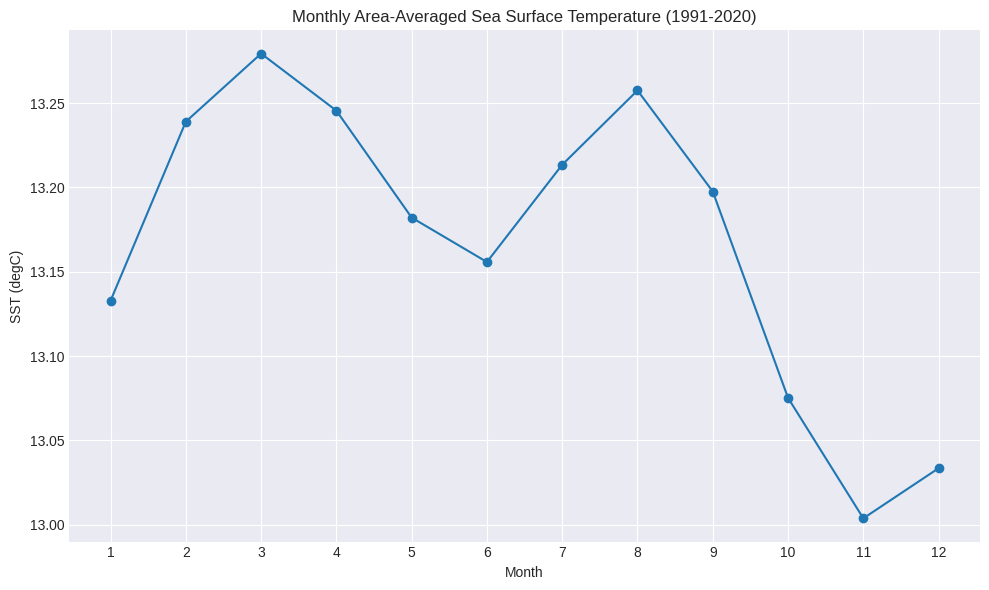

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import NoReturn
import sys

def plot_monthly_area_averaged_sst(nc_path: str, output_png: str) -> NoReturn:
    """
    Open a NetCDF file, compute monthly area-averaged SST, plot and save the figure.

    Parameters:
    - nc_path: str - Path to the NetCDF file
    - output_png: str - Path to save the output PNG plot
    """
    try:
        # Open dataset with xarray
        ds = xr.open_dataset(nc_path)
    except FileNotFoundError:
        print(f"Error: File not found: {nc_path}", file=sys.stderr)
        return
    except Exception as e:
        print(f"Error opening dataset: {e}", file=sys.stderr)
        return

    # Check if 'sst' variable exists
    if 'sst' not in ds.variables:
        print("Error: Variable 'sst' not found in dataset.", file=sys.stderr)
        return

    sst = ds['sst']

    # Check dimensions
    expected_dims = {'time', 'lat', 'lon'}
    if not expected_dims.issubset(sst.dims):
        print(f"Error: 'sst' variable missing expected dims {expected_dims}. Found dims: {sst.dims}", file=sys.stderr)
        return

    # Compute area weights based on latitude for proper averaging
    # Latitude in degrees, convert to radians for weighting
    lat_rad = np.deg2rad(ds['lat'].values)
    weights = np.cos(lat_rad)
    # Normalize weights to sum to 1 over lat dimension
    weights /= weights.sum()

    # Expand weights to match sst dims (time, lat, lon)
    # weights shape: (lat,) -> (lat, lon)
    # Since lon dimension is present, weights are broadcast along lon
    weights_2d = xr.DataArray(weights, dims=['lat'])  # shape (lat,)
    weights_2d = weights_2d.broadcast_like(sst.isel(time=0))

    # Multiply sst by weights and average over lat and lon
    # First multiply sst by weights along lat dimension
    weighted_sst = sst * weights_2d

    # Sum over lat and lon to get area average for each time
    # sum weights over lat and lon for normalization
    # weights_2d has shape (lat, lon) after broadcasting
    # But weights_2d currently only varies with lat, lon dimension is broadcasted
    # So sum weights over lat and lon:
    total_weights = weights_2d.sum(dim=['lat', 'lon'])

    # Compute weighted average SST for each time step
    area_avg_sst = weighted_sst.sum(dim=['lat', 'lon']) / total_weights

    # Plotting
    plt.figure(figsize=(10, 6))
    months = ds['time'].values
    # Convert time to month names if possible
    try:
        month_labels = [np.datetime_as_string(m, unit='M')[-2:] for m in months]
    except Exception:
        month_labels = [str(i+1) for i in range(len(months))]

    plt.plot(month_labels, area_avg_sst.values, marker='o', linestyle='-')
    plt.title('Monthly Area-Averaged Sea Surface Temperature (1991-2020)')
    plt.xlabel('Month')
    plt.ylabel(f'SST ({sst.attrs.get("units", "degC")})')
    plt.grid(True)
    plt.tight_layout()

    # Save plot to PNG
    plt.savefig(output_png, dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_monthly_area_averaged_sst("sst.mon.ltm.1991-2020.nc", "monthly_area_avg_sst.png")

Now, we can ask OpenAi via API to read the NC file first, get the data stucture and variables and then generate some python codes to plot the distributed global SST map at time=0 (first time step)

---
# Summary and Key Takeaways

## 🎯 Key Lessons from Chapter 4

### 1. **Literature Review Automation**
- Use SciBERT and domain-specific models for abstract screening
- Automatic summarization saves time on paper review
- Semantic search finds relevant papers better than keywords alone

### 2. **RAG Systems are Essential**
- Ground LLM responses in authoritative sources
- Combine retrieval with generation for accurate answers
- Always include citations for verification
- Use hybrid search (semantic + keyword) for best results

### 3. **Document Processing Matters**
- Chunk documents appropriately (500-1000 chars)
- Use domain-specific embeddings (SciBERT for science)
- Maintain metadata for proper citation tracking
- Build vector databases for efficient retrieval

### 4. **Quality Control is Critical**
- Verify all citations point to real sources
- Check for hallucinations using semantic similarity
- Evaluate retrieval quality with test questions
- Always have human experts review AI outputs

### 5. **Best Practices for Scientific AI**
- Document AI assistance in research
- Maintain human oversight of generated content
- Use appropriate temperature settings (low for factual, higher for creative)
- Combine AI with domain expertise

### 6. **Limitations to Remember**
- LLMs can hallucinate facts confidently
- Knowledge cutoffs mean missing recent research
- Citations may be fabricated without RAG
- Always verify important claims independently

---

## 🚀 Next Steps

1. **Build your own RAG system** with your research papers
2. **Experiment with different models** and embeddings
3. **Integrate AI assistants** into your workflow carefully
4. **Always verify** AI-generated content
5. **Continue to Chapter 5**: Data-to-Data Models

---

## 📚 Resources for Further Exploration

- **LangChain Documentation**: https://python.langchain.com
- **Hugging Face Models**: https://huggingface.co/models
- **SciBERT**: https://huggingface.co/allenai/scibert_scivocab_uncased
- **FAISS**: https://github.com/facebookresearch/faiss
- **Sentence Transformers**: https://www.sbert.net

---

## 🔑 Using OpenAI API (Optional)

To use GPT models, add your API key:

```python
import openai
openai.api_key = "your-api-key-here"

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "Your question"}]
)
```

---

*Remember: AI is a powerful tool for scientific research, but it's a tool that requires careful, informed use. Always verify, always cite, always think critically!* 🧪🔬
